In [48]:
import numpy as np
import scipy.stats as stat

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics, neighbors 

## Генерируем выборку

In [67]:
# количество элементов в каждой группе
N = 500

# k-fold cross validation will be used
K = 5

# первая группа
x1, y1 = stat.norm.rvs(size=(N, 2)) + np.array([-3, 3]), np.ones(N)

# вторая группа
x2, y2 = stat.norm.rvs(size=(N, 2)) + np.array([0, 0]), np.ones(N) * 2

# все тестовые данные
x, y = np.concatenate([x1, x2]), np.concatenate([y1, y2])

## Поглядим на выборку

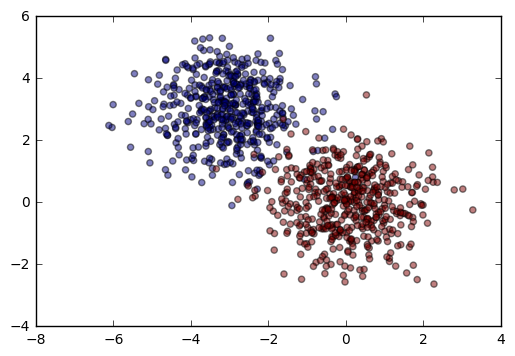

In [68]:
def show_scatter(x, y):
    plt.scatter(x[:, 0], x[:, 1], c = y, alpha=0.5)
    plt.show()
    
show_scatter(x, y)

Ну вроде норм, можно делать что-то интересное на такой выборке.

## Разделим данные на тренировочные и тестовые

(для кросс-валидации)

In [69]:
train_data, test_data, train_labels, test_labels = \
        cross_validation.train_test_split(
                x, y, 
                test_size = 1 / K, random_state = 1
        )

Скопируем некоторые функции из ноутбука с семинара. Они будут нужны для визуализации разделяющих поверхностей

In [75]:
# copied from seminar's notebook
colors = ListedColormap(['red', 'blue', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow'])

# copied from seminar's notebook
def get_meshgrid(data, step=.05, border=.5,):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

# copied from seminar's notebook
def plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels, 
                          colors = colors, light_colors = light_colors):
    #fit model
    estimator.fit(train_data, train_labels)
    
    #set figure size
    plt.figure(figsize = (16, 6))
    
    #plot decision surface on the train data 
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(estimator.predict(
            np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, cmap = colors)
    plt.title('Train data, accuracy={:.2f}'.format(
            metrics.accuracy_score(train_labels, estimator.predict(train_data))))
    
    #plot decision surface on the test data
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, s = 100, cmap = colors)
    plt.title('Test data, accuracy={:.2f}'.format(
            metrics.accuracy_score(test_labels, estimator.predict(test_data))))
    plt.show()

## Теперь построим график accuracy от k 
Где k это количество соседей 

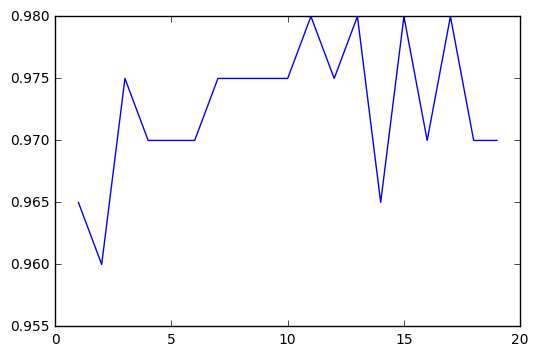

In [76]:
def get_accuracy_from_k(k):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(train_data, train_labels)
    predictions = clf.predict(test_data)
    return metrics.accuracy_score(test_labels, predictions)

ks = np.arange(1, 20, 1)
accuracy = np.array([get_accuracy_from_k(k) for k in ks])

plt.plot(ks, accuracy)
plt.show()


Заметим, что наилучшие результаты при k = 11, а дальше какой-то треш начинает твориться.
Посмотрим на эти наилучшие результаты

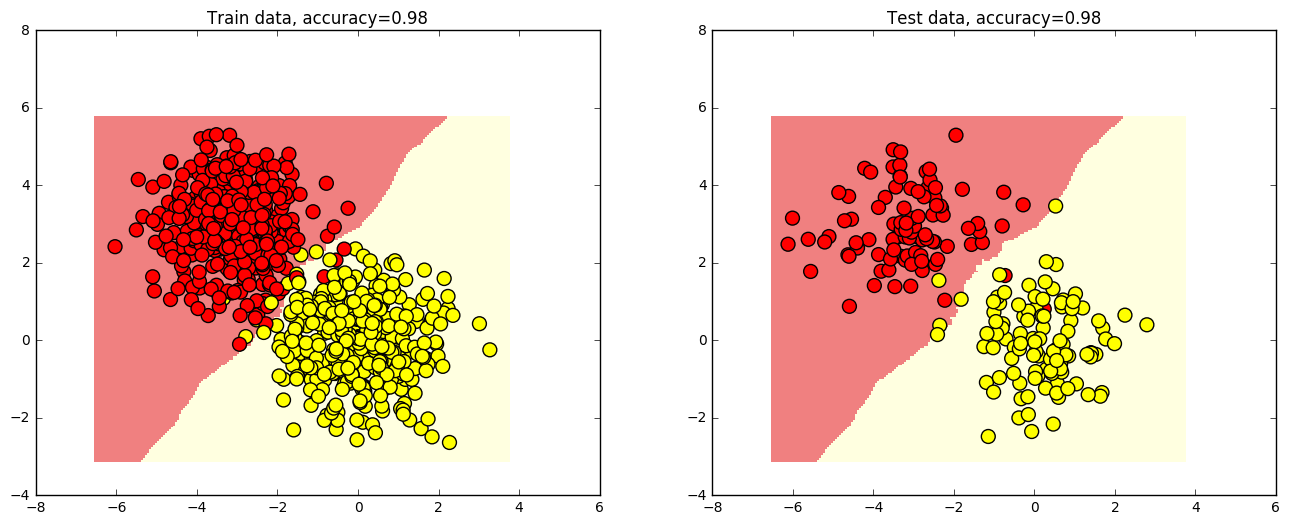

In [83]:
estimator = neighbors.KNeighborsClassifier(n_neighbors=11)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

Неплохо так, в целом, поверхность вполне поверхность

### Сравним с маленьким количеством соседей

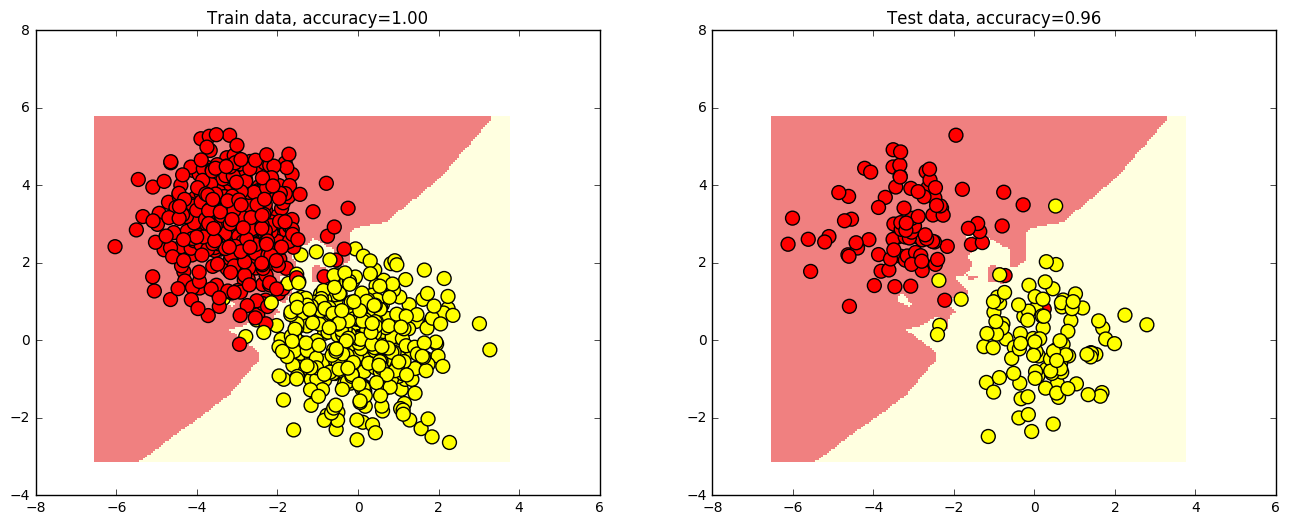

In [81]:
estimator = neighbors.KNeighborsClassifier(n_neighbors=1)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

Здесь разделяющая поверхность не особо поверхность. В зоне, где есть элементы первой и второй группы, есть шумы. Похоже на эффект переобучения

### Сравним с большим количеством соседей


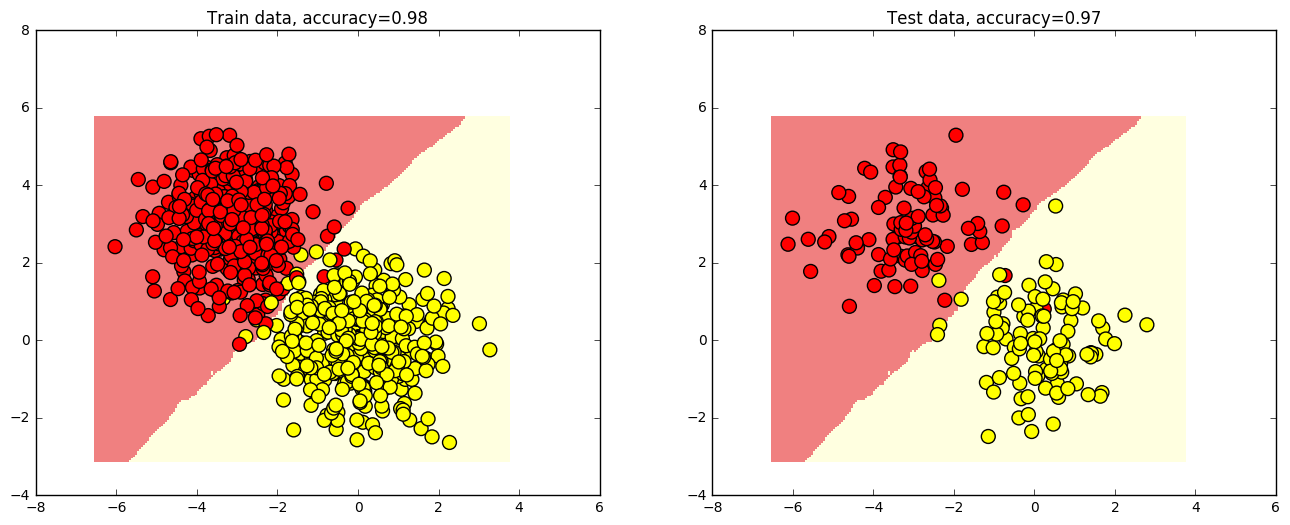

In [87]:
estimator = neighbors.KNeighborsClassifier(n_neighbors=20)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

По виду поверхность очень напоминает такую же при k = 11. То что она показывает худшие результаты можно, пожалуй отнести к случайным эффектам. Или к тому что излишне не учитывается специфика расположения точек на границе. Впрочем зная исходные распределения, скажу, что тут первый вариант.